In [1]:
# Tensorflow 2 version
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import glob

from tensorflow.keras import __version__
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (Activation, BatchNormalization, Dense, Dropout,
                                     Flatten, Input, MaxPooling2D, Conv2D)
from tensorflow.keras.models import Model

import utils.CNN_utils as cu

%matplotlib inline

save = False

### Helper functions

In [2]:
def load_data_from_images(image_path, datasplit):
    image_path = image_path
    data = {
        "Path": [
                 glob.glob(f"{image_path}/{datasplit}/asteroids/" + '*'), 
                 glob.glob(f"{image_path}/{datasplit}/other/" + '*')
                ],
        "Label": [1,0],
        "Set": datasplit
         }
    df = pd.DataFrame(data).explode('Path')
    df = df.sample(frac=1, random_state=35) #shuffle
    x = []
    y = []
    for i, file in enumerate(df['Path']):
        im = Image.open(file)
        im = np.asarray(im)
        x.append(im)
        y.append(df['Label'].iloc[i])
    
    return df, np.array(x, dtype=int), np.array(y, dtype=float)

### Load and process data

In [3]:
image_path = "/data/pg-ds_cit/Projects/Astronomy/AstronomyProject/Images"

trainSet, X_train, Y_train = load_data_from_images(image_path, 'train')
validSet, X_valid, Y_valid = load_data_from_images(image_path, 'valid')
testSet, X_test, Y_test = load_data_from_images(image_path, 'test')

In [4]:
print('Using Keras version:', __version__, 'with backend:', K.backend(), tf.__version__)

# Training hyperparameters
subtract_pixel_mean = False
epochs = 100 #500
early_stop_patience = 20
learning_rate = 0.001
batch_size = 256
# dr = 5 / epochs  # Parameter for Learning rate decay

# Make sure data is float32 to have enough decimals after normalization
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

# Normalize pixel values between 0 and 1
X_train /= 2**8
X_valid /= 2**8
X_test /= 2**8

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    X_train_mean = np.mean(X_train, axis=0)
    X_train -= X_train_mean
    X_valid -= X_train_mean
    X_test -= X_train_mean

# input image dimensions
img_rows, img_cols = X_train.shape[1:3]

# Convert to correct Keras format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

Using Keras version: 2.4.0 with backend: tensorflow 2.3.1


### Define model

In [5]:
print()
print('Data loaded: train:', len(X_train), 'valid:', len(X_valid), 'test:', len(X_test))
print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)

# number of convolutional filters to use
nb_filters = 64
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

dropoutProb = 0.25

input = Input(shape=input_shape)
x = BatchNormalization()(input)
x = Conv2D(nb_filters, kernel_size,
           padding='same',
           input_shape=input_shape,
           use_bias=True)(x)
#x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(nb_filters, kernel_size,
           padding='same',
           use_bias=True)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(dropoutProb)(x)


x = Conv2D(nb_filters*2, kernel_size,
           padding='same',
           use_bias=True)(x)
#x = BatchNormalization()
x = Activation("relu")(x)

x = Conv2D(nb_filters*2, kernel_size,
           padding='same',
           use_bias=True)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(dropoutProb)(x)


x = Conv2D(nb_filters*3, kernel_size,
           padding='same',
           use_bias=True)(x)
#x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(nb_filters*3, kernel_size,
           padding='same',
           use_bias=True)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

#x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(dropoutProb)(x)

x = Flatten()(x)
x = Dense(units=256, use_bias=True)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(dropoutProb*2)(x)

# out1 is the classification unit
out1 = Dense(units=1, activation='sigmoid', name='label')(x)

optimizer = optimizers.Adam(
    lr=learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=None,
    #decay=dr,
    amsgrad=False)

metrics = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    cu.f1_metric
    ]

model = Model(inputs=input, outputs=out1)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=["MeanAbsoluteError", metrics])

print(model.summary())


Data loaded: train: 1570 valid: 217 test: 190
X_train: (1570, 101, 101, 1)
Y_train: (1570,)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 101, 101, 1)]     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 101, 101, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 101, 101, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 101, 101, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 101, 101, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 101, 101, 64)      256       
___________________________

In [6]:
# Callback to stop training if val_loss hasn't decreased recently.
# Patience determines the number of epochs waited before stopping training.
earlyStopCB = EarlyStopping(
    monitor='val_loss',
    patience=early_stop_patience,
    verbose=1,
    restore_best_weights=True)

# Callback to save checkpoints of the best model so far.
checkpointCB = ModelCheckpoint(
    filepath='/data/p301081/astronomy/Models/checkpoint.hdf5',
    verbose=1,
    save_best_only=True,
    monitor='val_loss',
    save_weights_only=False,
    save_freq='epoch')

# Callback to reduce learning rate if val_loss hasn't improved recently.
LRCB = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=1,
    factor=0.2,
    patience=5,
    min_lr=0.00001)

### Train

In [7]:
# training
history = model.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[checkpointCB],  # Write desired callbacks between the brackets
                    shuffle=False)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.39408, saving model to /data/p301081/astronomy/Models/checkpoint.hdf5
7/7 - 4s - loss: 0.4055 - mean_absolute_error: 0.2164 - tp: 597.0000 - fp: 87.0000 - tn: 708.0000 - fn: 178.0000 - accuracy: 0.8312 - precision: 0.8728 - recall: 0.7703 - auc: 0.9098 - f1_metric: 0.8066 - val_loss: 0.3941 - val_mean_absolute_error: 0.3001 - val_tp: 92.0000 - val_fp: 10.0000 - val_tn: 100.0000 - val_fn: 15.0000 - val_accuracy: 0.8848 - val_precision: 0.9020 - val_recall: 0.8598 - val_auc: 0.9482 - val_f1_metric: 0.8804
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.39408
7/7 - 1s - loss: 0.2402 - mean_absolute_error: 0.1074 - tp: 735.0000 - fp: 57.0000 - tn: 738.0000 - fn: 40.0000 - accuracy: 0.9382 - precision: 0.9280 - recall: 0.9484 - auc: 0.9587 - f1_metric: 0.9383 - val_loss: 0.3946 - val_mean_absolute_error: 0.3038 - val_tp: 107.0000 - val_fp: 39.0000 - val_tn: 71.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.8203 - val_precision


Epoch 00017: val_loss did not improve from 0.39408
7/7 - 1s - loss: 0.0085 - mean_absolute_error: 0.0064 - tp: 775.0000 - fp: 3.0000 - tn: 792.0000 - fn: 0.0000e+00 - accuracy: 0.9981 - precision: 0.9961 - recall: 1.0000 - auc: 1.0000 - f1_metric: 0.9983 - val_loss: 2.4079 - val_mean_absolute_error: 0.5048 - val_tp: 107.0000 - val_fp: 110.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.7698 - val_f1_metric: 0.6605
Epoch 18/100

Epoch 00018: val_loss did not improve from 0.39408
7/7 - 1s - loss: 0.0053 - mean_absolute_error: 0.0050 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 2.6909 - val_mean_absolute_error: 0.5056 - val_tp: 107.0000 - val_fp: 110.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.7818 - val_f1_

Epoch 33/100

Epoch 00033: val_loss did not improve from 0.39408
7/7 - 1s - loss: 0.0011 - mean_absolute_error: 0.0011 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 2.9736 - val_mean_absolute_error: 0.5053 - val_tp: 107.0000 - val_fp: 110.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.5727 - val_f1_metric: 0.6605
Epoch 34/100

Epoch 00034: val_loss did not improve from 0.39408
7/7 - 1s - loss: 7.9521e-04 - mean_absolute_error: 7.9183e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 2.9603 - val_mean_absolute_error: 0.5052 - val_tp: 107.0000 - val_fp: 110.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - 

Epoch 49/100

Epoch 00049: val_loss did not improve from 0.39408
7/7 - 1s - loss: 5.0895e-04 - mean_absolute_error: 5.0436e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 2.0172 - val_mean_absolute_error: 0.4906 - val_tp: 107.0000 - val_fp: 110.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.9409 - val_f1_metric: 0.6605
Epoch 50/100

Epoch 00050: val_loss did not improve from 0.39408
7/7 - 1s - loss: 4.8491e-04 - mean_absolute_error: 4.8322e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 1.9144 - val_mean_absolute_error: 0.4862 - val_tp: 107.0000 - val_fp: 110.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1

Epoch 65/100

Epoch 00065: val_loss improved from 0.06082 to 0.05562, saving model to /data/p301081/astronomy/Models/checkpoint.hdf5
7/7 - 2s - loss: 9.3483e-04 - mean_absolute_error: 8.8589e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.0556 - val_mean_absolute_error: 0.0189 - val_tp: 107.0000 - val_fp: 3.0000 - val_tn: 107.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9862 - val_precision: 0.9727 - val_recall: 1.0000 - val_auc: 0.9952 - val_f1_metric: 0.9862
Epoch 66/100

Epoch 00066: val_loss did not improve from 0.05562
7/7 - 1s - loss: 0.0015 - mean_absolute_error: 0.0013 - tp: 774.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 1.0000 - accuracy: 0.9994 - precision: 1.0000 - recall: 0.9987 - auc: 1.0000 - f1_metric: 0.9995 - val_loss: 0.1352 - val_mean_absolute_error: 0.0541 - val_tp: 107.0000 - val_fp: 8.0000 - val_tn: 102.0000 - val_fn: 0.0000e+00 - val_accuracy

Epoch 81/100

Epoch 00081: val_loss did not improve from 0.05562
7/7 - 1s - loss: 2.7116e-04 - mean_absolute_error: 2.7039e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.1080 - val_mean_absolute_error: 0.0449 - val_tp: 107.0000 - val_fp: 6.0000 - val_tn: 104.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9724 - val_precision: 0.9469 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_metric: 0.9727
Epoch 82/100

Epoch 00082: val_loss did not improve from 0.05562
7/7 - 1s - loss: 2.3347e-04 - mean_absolute_error: 2.3317e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.1076 - val_mean_absolute_error: 0.0444 - val_tp: 107.0000 - val_fp: 6.0000 - val_tn: 104.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9724 - val_precision: 0.9469 - val_recall: 1.0000 - 

Epoch 97/100

Epoch 00097: val_loss improved from 0.05020 to 0.04718, saving model to /data/p301081/astronomy/Models/checkpoint.hdf5
7/7 - 2s - loss: 1.8828e-04 - mean_absolute_error: 1.8794e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.0472 - val_mean_absolute_error: 0.0171 - val_tp: 107.0000 - val_fp: 3.0000 - val_tn: 107.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9862 - val_precision: 0.9727 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_metric: 0.9862
Epoch 98/100

Epoch 00098: val_loss improved from 0.04718 to 0.04648, saving model to /data/p301081/astronomy/Models/checkpoint.hdf5
7/7 - 2s - loss: 2.1254e-04 - mean_absolute_error: 2.1180e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.0465 - val_mean_absolute_error: 0.0172 - val_tp: 

### Results and plots

50/50 - 1s - loss: 0.0011 - mean_absolute_error: 0.0011 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 0.9800
7/7 - 0s - loss: 0.0407 - mean_absolute_error: 0.0158 - tp: 107.0000 - fp: 3.0000 - tn: 107.0000 - fn: 0.0000e+00 - accuracy: 0.9862 - precision: 0.9727 - recall: 1.0000 - auc: 1.0000 - f1_metric: 0.9837
6/6 - 0s - loss: 0.0797 - mean_absolute_error: 0.0193 - tp: 94.0000 - fp: 2.0000 - tn: 93.0000 - fn: 1.0000 - accuracy: 0.9842 - precision: 0.9792 - recall: 0.9895 - auc: 0.9944 - f1_metric: 0.9831

Training set:

Classification accuracy, precision, recall: 100.00 100.00 100.00
TP, TN, FP, FN: 775 795 0 0

Validation set:

Classification accuracy, precision, recall: 98.62 97.27 100.00
TP, TN, FP, FN: 107 107 3 0

Test set:

Classification accuracy, precision, recall: 98.42 97.92 98.95
TP, TN, FP, FN: 94 93 2 1


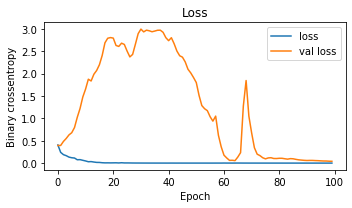

In [8]:
# Plot training loss and validation loss history.
plt.figure(figsize=(5, 3))
plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val loss")
plt.xlabel('Epoch')
plt.ylabel('Binary crossentropy')
plt.legend()
plt.title(f'Loss')
plt.tight_layout()
if save:
    plt.savefig(f"/data/p301081/astronomy/results/plots_kids/loss.png")

scoresTrain = model.evaluate(X_train, Y_train, verbose=2)
scoresValid = model.evaluate(X_valid, Y_valid, verbose=2)
scoresTest = model.evaluate(X_test, Y_test, verbose=2)
#print(scoresTrain, scoresTest)

predictionsTrain = model.predict(X_train)
predictionsValid = model.predict(X_valid)
predictionsTest = model.predict(X_test)

predictionsTrain = [round(pred[0]) for pred in predictionsTrain]
predictionsValid = [round(pred[0]) for pred in predictionsValid]
predictionsTest = [round(pred[0]) for pred in predictionsTest]

print("\nTraining set:")
train_set_metrics = cu.analyze_5unit_errors(predictionsTrain, Y_train)
print("\nValidation set:")
train_set_metrics = cu.analyze_5unit_errors(predictionsValid, Y_valid)
print("\nTest set:")
test_set_metrics = cu.analyze_5unit_errors(predictionsTest, Y_test)

if save:
    modelName = f"cnn_asteroids.h5"
    print("\nSaving model to", modelName)
    model.save(f"../Models/{modelName}")

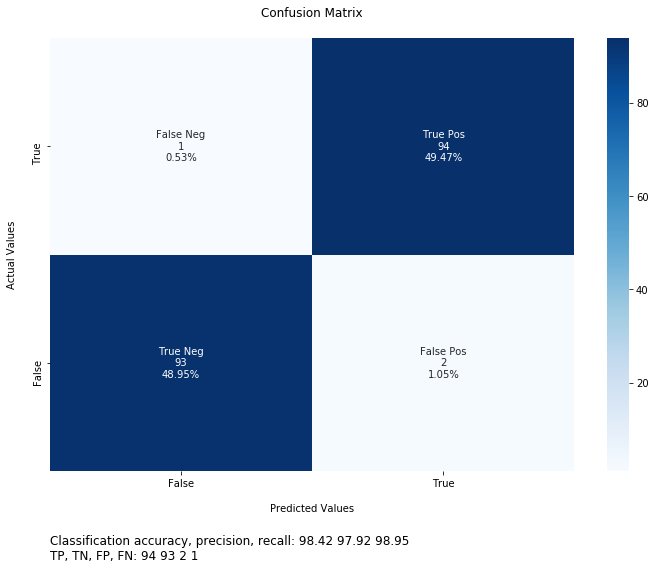

In [9]:
plt.figure(figsize=(10,8))

cf_matrix = confusion_matrix(Y_test, predictionsTest)
cf_matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(f'Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
ax.set_ylim([0,2])

ax.text(0, -0.2, test_set_metrics, wrap=True, horizontalalignment='left', fontsize=12, transform = ax.transAxes)

plt.tight_layout()

if save:
    plt.savefig(f"/data/p301081/astronomy/results/plots_kids/confusionMatrix.png")

plt.show()

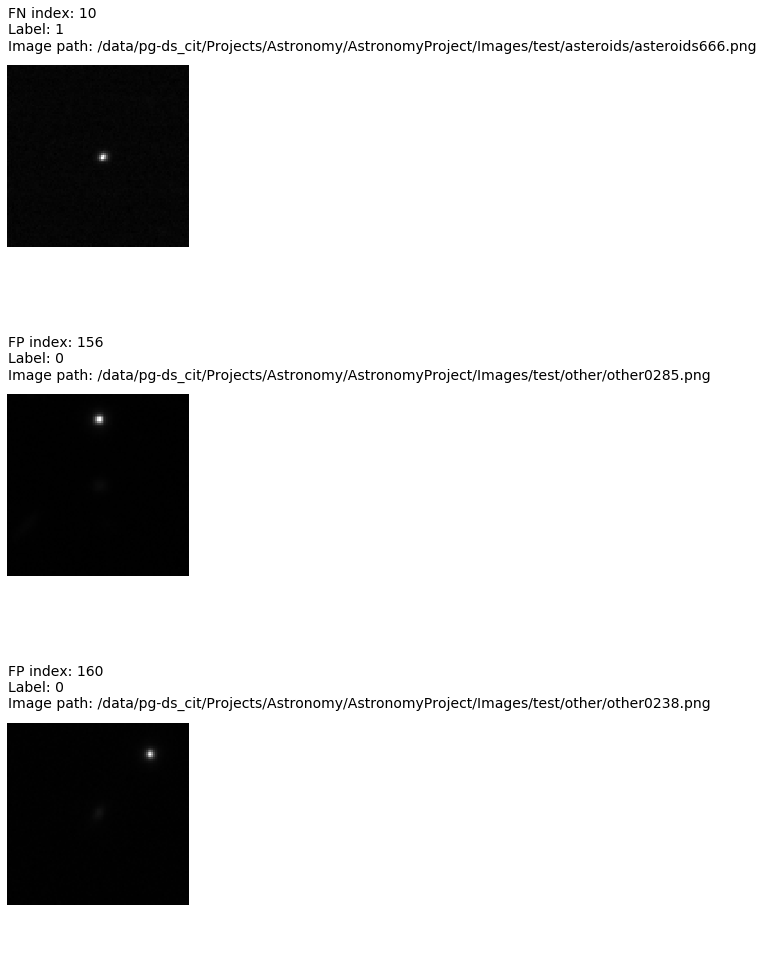

In [10]:
rows = int(group_counts[1]) + int(group_counts[2])
fig = plt.figure(figsize=(10,14))
plt.axis('off')
fig.suptitle(f'', y=.98, fontsize = 16)
plt.tight_layout() 
s = 1
for idx, (first, second) in enumerate(zip(predictionsTest, Y_test)):
    if first == 1 and first != second:
        fig.add_subplot(rows, 1, s)
        plt.imshow(X_test[idx,...,0], cmap='gray')
        plt_txt = f"FP index: {idx}\nLabel: {int(Y_test[idx])}\nImage path: {testSet['Path'].iloc[idx]}"
        plt.text(0, -10, plt_txt, wrap=True, horizontalalignment='left', fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        s+=1
    if first == 0 and first != second:
        fig.add_subplot(rows, 1, s)
        plt.imshow(X_test[idx,...,0], cmap='gray')
        plt_txt = f"FN index: {idx}\nLabel: {int(Y_test[idx])}\nImage path: {testSet['Path'].iloc[idx]}"
        plt.text(0, -10, plt_txt, wrap=True, horizontalalignment='left', fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        s+=1
plt.tight_layout()       
if save:
    plt.savefig(f"/data/p301081/astronomy/results/plots_kids/fp_fn.png")